# To-do 
- Debug Metropolis Monte Carlo step during training by energy so we can sample low-energy states efficiently. 
- Generally optimize methods in net.py (several redundant calls) 
- (quick and easy) generalize energy functions (they need to expect PyTorch tensors instead of numpy arrays). So for example every `np.sum()` should be `torch.sum()`, etc. 

# Setup

In [26]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import torch
from torch import distributions
from torch import nn
from torch.utils import data
from sklearn import datasets

import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
%load_ext autoreload
%autoreload 2 # Reload all modules every time before executing the Python code typed.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

# Define Ising Model

CPU times: user 336 µs, sys: 0 ns, total: 336 µs
Wall time: 339 µs


0.0625

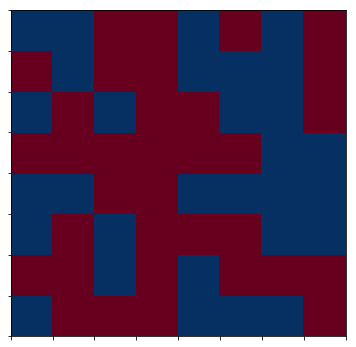

In [53]:
h = 0.0
J = 0.8
T = 1.0
N = 8

ising = IsingModel(h = h, J = J)
x0 = ising.init_coords(N)
ising.draw_config(x0)

%time ising.energy(torch.from_numpy(x0)) # energy of a given configuration 
ising.oprm(x0) # calculate average magnetization 

## Create training set
We'd like to have a $m$ x $N$ matrix containing our training data where $m$ is the number of realizations of the system and $N$ is the number of features (i.e. the flattened dimensions of the system). For example, a training set with 1000 samples of the Ising Model for $N=8$ would be of size (1000, 64). 

In [47]:
num_samples = 12800 # Use 1000 at run-time as done in Noe et al. for the biwell potential 
flattened_size = N**2

training_set = np.zeros((num_samples,flattened_size), dtype=np.float32)
for i in range(num_samples):
    training_set[i,:] = ising.init_coords(N).flatten() # generate random configuration 
training_set = torch.from_numpy(training_set) # convert to PyTorch tensor 

As an aside, note that although we flatten our configurations for training, the flattening procedure can easily be reversed via the `rehsape()` function: 

In [48]:
np.array(x0)

array([[-1, -1, -1,  1, -1,  1,  1,  1],
       [ 1, -1, -1,  1, -1,  1, -1,  1],
       [ 1, -1,  1,  1, -1, -1,  1, -1],
       [-1,  1, -1, -1, -1, -1, -1,  1],
       [-1, -1, -1, -1, -1,  1,  1,  1],
       [-1,  1,  1,  1, -1,  1,  1,  1],
       [ 1, -1,  1, -1,  1, -1, -1, -1],
       [-1, -1, -1, -1,  1, -1, -1, -1]])

In [49]:
np.array(x0).flatten().reshape((N,N))

array([[-1, -1, -1,  1, -1,  1,  1,  1],
       [ 1, -1, -1,  1, -1,  1, -1,  1],
       [ 1, -1,  1,  1, -1, -1,  1, -1],
       [-1,  1, -1, -1, -1, -1, -1,  1],
       [-1, -1, -1, -1, -1,  1,  1,  1],
       [-1,  1,  1,  1, -1,  1,  1,  1],
       [ 1, -1,  1, -1,  1, -1, -1, -1],
       [-1, -1, -1, -1,  1, -1, -1, -1]])

## Histogram energies of training set

Previously I was calculating energy as: 

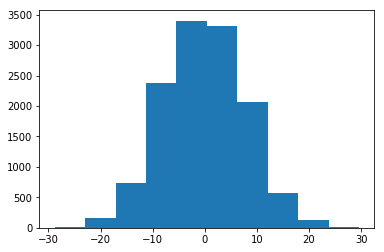

In [50]:
plt.hist(ising.energy_vec(training_set))
plt.show()

Which is clearly different from: 

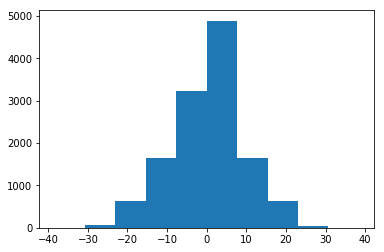

In [51]:
energies = []
for i in range(training_set.shape[0]):
    energies.append(ising.energy(training_set[i,:].reshape((N,N))))
plt.hist(energies)
plt.show()

Histogram Boltzmann weights:

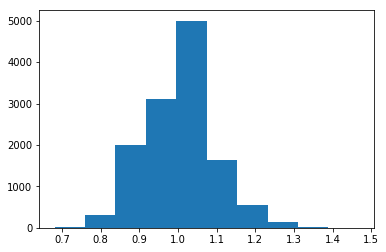

In [57]:
# KH I added a temperature so the weights could be visualized
weights = np.exp(-np.array(energies)/100)
plt.hist(weights)
plt.show()

# Boltzmann generator
## Define network architecture 
In the following we use 3 hidden layers for the translation and scaling networks and a total of four stacked RealNVP blocks (as defined by `masks`). 

In [60]:
n_hidden = 100 # number of hidden layers
nets = lambda: nn.Sequential(nn.Linear(N**2, n_hidden), nn.Tanh(), nn.Linear(n_hidden, n_hidden), nn.Tanh(), nn.Linear(n_hidden, N**2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(N**2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, N**2)) # net t

first_mask = np.array(np.concatenate((np.ones(round(N**2/2)), np.zeros(round(N**2/2)))))
masks_np = np.stack(
                    ( first_mask, np.flip(first_mask, axis=0),
                      first_mask, np.flip(first_mask, axis=0),
                      first_mask, np.flip(first_mask, axis=0),
                      first_mask, np.flip(first_mask, axis=0) )
                   ) 
masks = torch.from_numpy(masks_np.astype(np.float32))

prior = distributions.MultivariateNormal(torch.zeros(N**2), torch.eye(N**2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
network = net.RealNVP(nets, nett, masks, prior, ising, x0.shape)

# network.system.energy(network.g(training_set)) # energy functions need to be rewritten with PyTorch tensors in mind

Note that $\log R_{xz} = - \log R_{zx}$, as demonstrated below: 

In [61]:
z, log_Rxz = network.f(training_set[0:1,:])
x, log_Rzx = network.g(z)
print(log_Rzx)
print(log_Rxz)

tensor([1.1162], grad_fn=<AddBackward0>)
tensor([-1.1162], grad_fn=<SubBackward0>)


Energies can not be calculated via the `calculate_energy()` method of the network. 

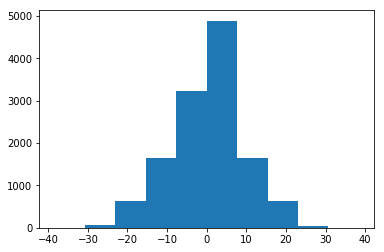

In [62]:
plt.hist(network.calculate_energy(training_set))
plt.show()

We can calculate the average energy using the Boltzmann weights as: 

In [63]:
network.expected_value(network.calculate_energy(training_set), training_set)

tensor(-38.3434)

## Train model 
The training schedule accordingly the main text of Noe et al. is as follows: 
- Begin with a buffer of 10,000 real space configurations 
- Train by example, minimizing $J_{ML}$, using a batch size of 128 for 20 iterations (JB: so not even one full epoch?)
- Switch to batch size of 1000 and for each batch (iteration) we now perform a Metropolis Monte Carlo step in latent space for each sample in the given batch. 

### Train by example first
Minimizing $J_{ML}$.

In [ ]:
optimizer = torch.optim.Adam([p for p in network.parameters() if p.requires_grad==True], lr=1e-4)
trainloader = data.DataLoader(dataset=training_set, batch_size=128)

losses = []
avg_energy = []
t = 0 
for epoch in range(300):
    for batch in trainloader:  
        z, log_det_J = network.f(batch)
              
        loss = network.loss_ml(batch)
        losses.append(loss.item()) # save values for plotting later 
        
        avg_energy.append(network.expected_value(network.energies, training_set))

        optimizer.zero_grad() # we need to set the gradients to zero before starting to do 
                              # backpropragation because PyTorch accumulates the gradients on 
                              # subsequent backward passes.
        loss.backward(retain_graph=True)
        optimizer.step()
        t = t + 1 # iteration count

        if t % 100 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 100: loss = -7.019
iter 200: loss = -28.649
iter 300: loss = -32.306
iter 400: loss = -33.711
iter 500: loss = -34.739
iter 600: loss = -35.531
iter 700: loss = -36.169
iter 800: loss = -36.741
iter 900: loss = -37.226
iter 1000: loss = -37.749
iter 1100: loss = -38.240
iter 1200: loss = -38.728
iter 1300: loss = -39.190
iter 1400: loss = -39.712
iter 1500: loss = -39.988
iter 1600: loss = -40.998
iter 1700: loss = -41.413
iter 1800: loss = -42.038
iter 1900: loss = -42.704
iter 2000: loss = -43.114
iter 2100: loss = -44.401
iter 2200: loss = -44.308
iter 2300: loss = -44.816
iter 2400: loss = -45.664
iter 2500: loss = -46.279
iter 2600: loss = -47.310
iter 2700: loss = -49.106
iter 2800: loss = -49.383
iter 2900: loss = -50.517
iter 3000: loss = -49.875
iter 3100: loss = -51.652
iter 3200: loss = -51.477
iter 3300: loss = -53.279
iter 3400: loss = -54.120
iter 3500: loss = -55.063
iter 3600: loss = -56.216
iter 3700: loss = -55.933
iter 3800: loss = -56.397
iter 3900: loss = -57.

### Next train by both example and by energy 
Minimizing linear combination of $J_{ML}$ and $J_{KL}$.

In [ ]:
optimizer = torch.optim.Adam([p for p in network.parameters() if p.requires_grad==True], lr=1e-4)

s = 0.1 # Metropolis Monte Carlo step size 
m = distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0])) # uniform distribution

t = 0
for epoch in range(500): 
    trainloader = data.DataLoader(dataset=training_set, batch_size=128)
    for batch in trainloader:   

        loss = network.loss_ml(batch) + network.loss_kl(batch)
        losses.append(loss.item())
        
        avg_energy.append(network.expected_value(network.energies, training_set))

        optimizer.zero_grad() # we need to set the gradients to zero before starting to do 
                              # backpropragation because PyTorch accumulates the gradients on 
                              # subsequent backward passes.
        loss.backward(retain_graph=True)
        optimizer.step()
        t = t + 1 # iteration count

        # Metropolis Monte Carlo step (almost completely vectorized) 
#         z, log_R_xz = network.f(batch)
#         z_prop = z + s*prior.sample((z.shape[0],)) # proposed move in latent space
#         x_prop, log_R_zx = network.g(z_prop) # corresponding position in real space
        
#         delta_E = torch.zeros_like(log_R_xz)
#         for i in range(batch.shape[0]): # for each x in the batch 
#             delta_E[i] = ising.energy(x_prop[i,:].reshape((N,N))) - ising.energy(batch[i,:].reshape((N,N))) - log_R_zx[i] + log_R_xz[i]
#         acceptance_ratio = torch.min(torch.ones(delta_E.shape), torch.exp(-delta_E))
#         mask = torch.rand(acceptance_ratio.shape) <= acceptance_ratio
        
#         for i in range(batch.shape[0]): # for each x in the batch 
#             if mask[i]: # accept candidate 
#                 training_set[i,:] = x_prop[i,:]

        if t % 100 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 100: loss = 49.136
iter 200: loss = -5.507
iter 300: loss = -45.883
iter 400: loss = -69.317
iter 500: loss = -97.285
iter 600: loss = -112.007
iter 700: loss = -119.569
iter 800: loss = -122.931
iter 900: loss = -125.471
iter 1000: loss = -128.172
iter 1100: loss = -131.148
iter 1200: loss = -134.297
iter 1300: loss = -137.528
iter 1400: loss = -140.794
iter 1500: loss = -144.054
iter 1600: loss = -147.040
iter 1700: loss = -149.371
iter 1800: loss = -150.939
iter 1900: loss = -151.917
iter 2000: loss = -152.547
iter 2100: loss = -153.007
iter 2200: loss = -153.397
iter 2300: loss = -153.766
iter 2400: loss = -154.132
iter 2500: loss = -154.491
iter 2600: loss = -154.828
iter 2700: loss = -155.121
iter 2800: loss = -155.344
iter 2900: loss = -155.499
iter 3000: loss = -155.610
iter 3100: loss = -155.693
iter 3200: loss = -155.760
iter 3300: loss = -155.817
iter 3400: loss = -155.866
iter 3500: loss = -155.910
iter 3600: loss = -155.950
iter 3700: loss = -155.987
iter 3800: loss =

Debugging trail:

In [ ]:
# print(ising.energy(x_prop[i,:].reshape((N,N)))) # none?
# print(-ising.energy(batch[i,:].reshape((N,N)))) # works fine 
# print( - log_R_zx[i]) # NaN
# print(log_R_xz[i]) # NaN
# print(x_prop) # NaN
# print(z_prop) # NaN
# print(z) # NaN
print(network.f(batch)) # NaN

## Visualize results
### View loss as a function of iteration steps
Training should proceed until the loss approximately levels out. 

In [ ]:
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))
# Edit the layout
fig.update_layout(yaxis_title='Loss',
                   xaxis_title='Iteration #')

### View average energy as a function of iteration steps
We should see the average energy decrease once we perform adaptive sampling during training by energy. 

In [ ]:
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=avg_energy,
                    mode='lines',
                    name='lines'))
# Edit the layout
fig.update_layout(yaxis_title='Avg. Energy',
                   xaxis_title='Iteration #')